In [1]:
from brian2 import *
#from brian2tools import *
import numpy as np
%matplotlib inline


In [2]:
# SIMULATION PARAMETERS

prefs.codegen.target = 'numpy'
# the numerical resolution method that shall be used by Brian
diff_method = "euler"
time_step = 0.01 * ms
defaultclock.dt = time_step 

In [3]:
################################## NEURONS AND SYNAPSES PARAMETERS ################################## 

######### (A) Neuronal parameters, used in (1) and (4) ########

# time constants
tau_m = 1.0 * ms # ok
tau_m_inh = 0.5 * ms # ok
# membrane potential after reset
v_rest = 0.0 # ok
# spiking threshold
theta_u = 0.5 # ok
theta_inh = 0.01 # ok

########## (B) Synaptic parameters, used in (2) and (3) for different synapse types ######### 

# temporal layer to som layer (u to v)
tau_r_afferent = 0.2 * ms
tau_f_afferent = 1.0 * ms

# temporal layer (u to inh exc, u to inh inh, inh to u)
tau_r_exc = 0.4 * ms
tau_f_exc = 2.0 * ms
tau_r_inh = 0.2 * ms
tau_f_inh = 1.0 * ms
tau_r_inh2u = 1.0 * ms
tau_f_inh2u = 5.0 * ms

########## (C) Maximum magnitudes of synaptic connection strength ##########
w_syn_u2inh_exc_max = 1.0
w_syn_u2inh_inh_max = 1.0
w_syn_inh2u_max = 100.0

In [4]:
class ReceptiveField:
    # Parameter used in standard deviation definition
    gamma = 1.5

    def __init__(self, bank_size = 10, I_min =0.05 , I_max =0.95 ):
        # number of units used to encode a real value  
        self.bank_size = bank_size
        # field_mu corresponds to the mean of the gaussian and shall be a numpy array 
        self.field_mu = np.zeros(bank_size)
        for i in range (bank_size): 
            mui = I_min + (((2*(i+1)-2)/2)*(I_max - I_min)/(bank_size-1))
            self.field_mu[i] = mui
        # field_sigma corresponds to the standard deviation of the gaussian and shall be a float
        self.field_sigma = 1/self.gamma * (I_max - I_min)
        
    def float_to_potential(self, input_vector):
        try:
            input_vector = input_vector.reshape((input_vector.shape[0], 1))
            #self.field_mu = self.field_mu.reshape((self.field_mu.shape[0], 1))
            
        except Exception as exc:
            print("Exception: {0}\nObject shape: {1}".format(repr(exc), input_vector.shape))
            exit(1)
            
        #résultat de f(x)
        result = e**(-((input_vector - self.field_mu)**2) /2*self.field_sigma)
        return result

In [19]:
rf = ReceptiveField()
inp_vector = np.random.uniform(0,1,2)
inp_vector

array([0.38460754, 0.9206988 ])

In [20]:
rf.field_sigma  # 0.59999999

0.5999999999999999

In [21]:
inp_potentials = rf.float_to_potential(inp_vector) # il me semble que ça devait un tableau genre gaussienne avec 1 au milieu 
inp_potentials

array([[0.96696917, 0.98362337, 0.99457899, 0.99964076, 0.99871797,
        0.99182718, 0.97909173, 0.96073804, 0.93708898, 0.90855433],
       [0.79657426, 0.83678092, 0.87375867, 0.90691266, 0.9356936 ,
        0.95961292, 0.97825652, 0.99129667, 0.99850163, 0.99974246]])

## notes séance 06/02
c'est le temps d'émission qui encode l'information 
c'est une propagation 

Tous les neurones sont les mêmes dans u et v c'est les mêmes modèles mais avec des paramètre différents 
fèche exitateur
flèche plate inhibiteur 

c'est dans le modèle des synapse qu'on mettra les fonctions alpha 
u = à la somme des poids des synapses 
w le poids synaptique

fonctions alpha les règles des synapses 

pas obligé de faire l'apprentissage dans un premier temps 

eq 5 : adapter les poids synaptiques
    --> en fonction de ce qui est reçu on applique une règle ou l'autre 
    
    
summed variable sert pour l'eq 4 

eq 6 : implémenter la différence de gaussienne 

eq 7 réduire le rayon au cours du temps
    T n'est pas donné (essayer 10 on peut jouer avec)
    n non plus n=1 on peut essayer de le faire varier 

In [26]:
# à adapter, peret de calculer la distance toroidale
# permet de calculer le vecteur d'entrée de u
# implémenter le noyer d'interraction pour la pop v
def toroidalDistance(x1,x2):
    dx = np.abs(x1 - x2)
    tor_dist = np.where(dx < 0, dx, 1.0 - dx)
    return tor_dist

In [32]:

u_layer_neuron_equ = '''
I_ext : 1

# inhibitory synapses to u layer : alpha functions
ds_inh2u/dt = (-s_inh2u)/tau_r_inh2u:1
dI_inh2u/dt = (s_inh2u-I_inh2u)/tau_f_inh2u :1

# membrane potential of u layer 
dv/dt = (-v +I_ext - I_inh2u) / tau_m:1
'''

model_synapse_inh2u_inhibition = '''
w_syn : 1
'''

on_pre_synapse_inh2u_inhibition = '''
s_inh2 += w_syn
'''


In [33]:
start_scope()

N = 10
U = NeuronGroup(N,u_layer_neuron_equ, threshold='v>0.5', reset='v=0', method='exact')


In [34]:
print(inp_potentials)
distance = toroidalDistance(inp_potentials[0],[1])

U.I_ext = distance

[[0.96696917 0.98362337 0.99457899 0.99964076 0.99871797 0.99182718
  0.97909173 0.96073804 0.93708898 0.90855433]
 [0.79657426 0.83678092 0.87375867 0.90691266 0.9356936  0.95961292
  0.97825652 0.99129667 0.99850163 0.99974246]]


WARNING    "I_inh2u" is an internal variable of group "neurongroup", but also exists in the run namespace with the value 0. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    <string>:15: RuntimeWarning: invalid value encountered in double_scalars
 [py.warnings]
WARNING    <string>:19: RuntimeWarning: invalid value encountered in greater
 [py.warnings]
WARNING    neurongroup's variable 'v' has NaN, very large values, or encountered an error in numerical integration. This is usually a sign that an unstable or invalid integration method was chosen. [brian2.groups.group.invalid_values]


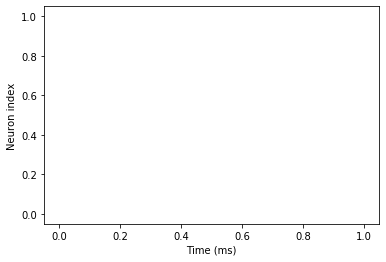

In [35]:
spikemon = SpikeMonitor(U, variables='v')

run(100*ms)
plot(spikemon.t/ms, spikemon.i, '.k')
xlabel('Time (ms)')
ylabel('Neuron index');

In [10]:
# partie copiée de la partie 6 aide
net_model = Network(collect())
net_model.store()

for epoch in range (nb_epoch):
    np.random.shuffle(dataset)
    for vector in enumerate(dataset):
        for oscil in range(nb_oscil):
            net_model.restore()
            potential_input = rf.float_to_membrane_potential(vector)
            u_layer.I_ext = potential_input.flatten()
            net_model.run(oscillation_period)
            net_model.store()

NameError: name 'nb_epoch' is not defined